In [49]:
import os
import sys
import time
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
from torch.nn.modules.loss import _Loss
from torch.autograd import Variable
import concurrent.futures
import numpy as np
import pickle as pkl
import argparse
from PIL import Image
import pcl
sys.path.append('/home/kulunu/PVN3D/pvn3d')
print(sys.path)
from matplotlib import pyplot as plt
import json

['/home/kulunu/anaconda3/envs/pvn3d/lib/python36.zip', '/home/kulunu/anaconda3/envs/pvn3d/lib/python3.6', '/home/kulunu/anaconda3/envs/pvn3d/lib/python3.6/lib-dynload', '', '/home/kulunu/anaconda3/envs/pvn3d/lib/python3.6/site-packages', '/home/kulunu/anaconda3/envs/pvn3d/lib/python3.6/site-packages/IPython/extensions', '/home/kulunu/.ipython', '/home/kulunu/PVN3D/pvn3d', '/home/kulunu/PVN3D/pvn3d', '/home/kulunu/PVN3D/pvn3d']


In [50]:
from lib import PVN3D
from lib.utils.sync_batchnorm import convert_model
from lib.utils.basic_utils import Basic_Utils
from lib.utils.meanshift_pytorch import MeanShiftTorch
from common import Config
config = Config(dataset_name='Adapt')
bs_utils = Basic_Utils(config)

config_ad = Config(dataset_name='Adapt')
bs_utils_ad = Basic_Utils(config_ad)

inside Adapt <<<Adapt
inside Adapt <<<Adapt


In [51]:
checkpoint = '/home/kulunu/PVN3D/pvn3d/train_log/Adapt/checkpoints/pvn3d_8_kps.pth.tar'
#dat_dir = '/home/kulunu/Desktop/ADAPT_Competition/ADAPT_Pose_Estimation/ADAPT_FB2/validation/'
#dat_dir = '/home/kulunu/PVN3D/pvn3d/datasets/Adapt/Adapt_dataset'
dat_dir = '/home/kulunu/Desktop/ADAPT_Competition/ADAPT_Pose_Estimation_test_split/adapt_fb2_test/test/'
mesh_files_path = '/home/kulunu/PVN3D/pvn3d/datasets/Adapt/Adapt_dataset/models'
corners_txt_path = '/home/kulunu/PVN3D/pvn3d/datasets/Adapt/Adapt_object_kps/'
n_models = 3

scene_id_leading_zeros = 6
img_id_leading_zeros = 6
rgb_format = '.jpg'
dpt_format = '.png'
cam_scale = 1
use_given_K = True


class Adapt():
    
    def __init__(self, scene_id):

        self.dir = dat_dir + str(scene_id).zfill(scene_id_leading_zeros)
        self.dept_div = 30
        if dat_dir == '/home/kulunu/PVN3D/pvn3d/datasets/Adapt/Adapt_dataset':
            self.dir = dat_dir
            self.dept_div = 3
        self.rgb_dir = self.dir +'/rgb'  
        self.dpt_dir = self.dir+'/depth'    
        self.mesh = {}
        self.corners = {}

        for i in range(1, n_models + 1):
                self.mesh[str(i)] = np.array(pcl.load(mesh_files_path+'/obj_'+str(i)+'.pcd'))
                self.corners[str(i)] = np.loadtxt(corners_txt_path+str(i)+'/corners.txt')

    def get_item(self, im_id):
        

        with Image.open(os.path.join(self.rgb_dir,str(im_id).zfill(img_id_leading_zeros)+ rgb_format)) as ri:
            rgb = np.array(ri)[:, :, :3]
        rgb = np.transpose(rgb, (2, 0, 1))
       
        with Image.open(os.path.join(self.dpt_dir,str(im_id).zfill(img_id_leading_zeros)+ dpt_format)) as di:
            dpt = np.array(di)
            dpt = dpt/65535         
            dpt = dpt*self.dept_div
            
        if use_given_K :
                    with open(os.path.join(self.dir,'scene_camera.json'), "r") as f:
                        mat = json.load(f)
                        K = np.array(mat[str(im_id)]['cam_K']).reshape(3,3)
        else :
             K = np.array([[615.1397026909722, 0.0, 322.78683465719223], [0.0, 615.4323641853988, 244.22407517651774], [0.0, 0.0, 1.0]]) #camera insintric

        cld, choose = bs_utils.dpt_2_cld(dpt, cam_scale, K)
        rgb_lst = []

        for ic in range(rgb.shape[0]):
            rgb_lst.append(
                rgb[ic].flatten()[choose].astype(np.float32)
            )
        rgb_pt = np.transpose(np.array(rgb_lst), (1, 0)).copy()
        choose = np.array([choose])
        choose_2 = np.array([i for i in range(len(choose[0, :]))])

        if len(choose_2) < 400:
            print("Valid points are less than 400")
        if len(choose_2) > config.n_sample_points:
            c_mask = np.zeros(len(choose_2), dtype=int)
            c_mask[:config.n_sample_points] = 1
            np.random.shuffle(c_mask)
            choose_2 = choose_2[c_mask.nonzero()]
            print("Valid points are more than configured")
        else:
            leng = len(choose_2)
            choose_2 = np.pad(choose_2, (0, config.n_sample_points-len(choose_2)), 'wrap')
            print("Valid points are optimum")

        cld_rgb = np.concatenate((cld, rgb_pt), axis=1)
        cld_rgb = cld_rgb[choose_2, :]
        cld = cld[choose_2, :]
        normal = bs_utils.get_normal(cld)[:, :3]
        normal[np.isnan(normal)] = 0.0
        cld_rgb_nrm = np.concatenate((cld_rgb, normal), axis=1)
        choose = choose[:, choose_2]
        data_torch = [torch.from_numpy(rgb[np.newaxis, ...].astype(np.float32)), torch.from_numpy(cld_rgb_nrm[np.newaxis, ...].astype(np.float32)),torch.LongTensor(choose[np.newaxis, ...].astype(np.int32))]

        return data_torch, rgb, self.mesh, self.corners,K

In [52]:
def load_checkpoint(model=None, optimizer=None, filename="checkpoint"):
    filename = "{}.pth.tar".format(filename)

    if os.path.isfile(filename):
        #print("==> Loading from checkpoint '{}'".format(filename))
        try:
            checkpoint = torch.load(filename)
        except:
            checkpoint = pkl.load(open(filename, "rb"))
        epoch = checkpoint["epoch"]
        it = checkpoint.get("it", 0.0)
        best_prec = checkpoint["best_prec"]
        if model is not None and checkpoint["model_state"] is not None:
            model.load_state_dict(checkpoint["model_state"])
        if optimizer is not None and checkpoint["optimizer_state"] is not None:
            optimizer.load_state_dict(checkpoint["optimizer_state"])
        #print("==> Done")
        return it, epoch, best_prec
    else:
        print("==> Checkpoint '{}' not found".format(filename))
        return None

In [53]:
def evaluate(scn_id, im_id,model):   

    item = Adapt(scn_id)
    data_torch , rgb_img, mesh, corners,K = item.get_item(scn_id)
    # data_torch , rgb_img, mesh, corners,K = item.get_item(obj_ id,img_id,scene_id)

    model.eval()
    """"
    if model.training:
        print('model state in training')
    else:
        print('model state not in training')
    """

    #print('Started data acquisition')
    with torch.set_grad_enabled(False): # Data Acquisition

        cu_dt = [item.contiguous().to("cuda", non_blocking=True) for item in data_torch]
        rgb, cld_rgb_nrm, choose = cu_dt#.contiguous()

        # The 3 main per-point predictions for all seeds
        #  Mk = 307200 * 3 [offset to Kps of each object 1,2,3]
        #  Ms = 307200 * 3 [0 or 1 representatioon whther each point belongs to 1,2,3]
        #  Mc = 307200 * 3 [offset center of each object 1,2,3]

        pred_kp_of, pred_rgbd_seg, pred_ctr_of = model(
            cld_rgb_nrm, rgb, choose
        )
        print('The shape of pred_kp_of :', np.shape(pred_kp_of))
        print('The shape of pred_seg :', np.shape(pred_rgbd_seg))
        print('The shape of pred_ctr_of :', np.shape(pred_ctr_of[0][0]))


        _, classes_rgbd = torch.max(pred_rgbd_seg, -1)
        print('classes_rgbd :', np.shape(classes_rgbd) )
        print('shape of pcld :', np.shape(cld_rgb_nrm[0][:,:3]) )

        ############################################################
        pcld  = cld_rgb_nrm[0][:,:3]
        mask  = classes_rgbd[0] 
        ctr_of = pred_ctr_of[0]  
        pred_kp_of = pred_kp_of[0] 
        use_ctr = True 
        n_cls  = config.n_objects 
        use_ctr_clus_flter = True 
        ds = 'Adapt'
        ############################################################

        # n_kps = 8 . n_pts = 12288
        n_kps, n_pts, _ = pred_kp_of.size()
        

        #predicted_ctr (not sure if this is the meaning) = pcld - predicted_ctr_offset
        pred_ctr = pcld - ctr_of[0]    
        print('The shape of pred_ctr :', np.shape(pred_ctr))
        
        # reshape pcld to the size of pred_kp_of
        # predicted_kps = pcld - predicted_kp_offsets                                      
        pred_kp = pcld.view(1, n_pts, 3).repeat(n_kps, 1, 1) - pred_kp_of
        print('The shape of pred_kp :', np.shape(pred_kp))

        #radius=0.08
        radius = 0.08
        # If center is considered extra keypoint, cls kps = 9, else = 8
        if use_ctr:
            cls_kps = torch.zeros(n_cls, n_kps+1, 3).cuda()
        else:
            cls_kps = torch.zeros(n_cls, n_kps, 3).cuda()

        print('The shape of mask :',np.shape(mask)) ## torch.Size([12288]) with cls ids
 
        # 1. predicted_cls_ids as unique list : [1 2 3]
        pred_cls_ids = np.unique(mask[mask>0].contiguous().cpu().numpy())
        print('The array pred_cls_ids :',pred_cls_ids)
  
        # Not used, skip
        ######################################################################################
        if use_ctr_clus_flter:
           ctrs = []
           for icls, cls_id in enumerate(pred_cls_ids):
               #cls_mask = torch.Size([1, 12288]) where non class indexes = 0
               cls_msk = (mask == cls_id)

               # This is the hough voting 
               # Mean shift clustering aims to discover “blobs” in a smooth density of samples
               ms = MeanShiftTorch(bandwidth=radius)
               ctr, ctr_labels = ms.fit(pred_ctr[cls_msk, :])
               ctrs.append(ctr.detach().contiguous().cpu().numpy())

           ctrs = torch.from_numpy(np.array(ctrs).astype(np.float32)).cuda()
           n_ctrs, _ = ctrs.size()
           pred_ctr_rp = pred_ctr.view(n_pts, 1, 3).repeat(1, n_ctrs, 1)
           ctrs_rp = ctrs.view(1, n_ctrs, 3).repeat(n_pts, 1, 1)
           ctr_dis = torch.norm((pred_ctr_rp - ctrs_rp), dim=2)
           min_dis, min_idx = torch.min(ctr_dis, dim=1)
           msk_closest_ctr = torch.LongTensor(pred_cls_ids).cuda()[min_idx]
           new_msk = mask.clone()

           for cls_id in pred_cls_ids:
               if cls_id == 0:
                   break
               if ds =='ycb':
                   min_msk = min_dis < config.ycb_r_lst[cls_id-1] * 0.8
               else:
                   min_msk = min_dis < config_ad.Adapt_r_lst[cls_id-1] * 0.8   #Changed to Adapt from Crankslider
               #min_msk = min_dis < config.ycb_r_lst[cls_id-1] * 0.8
               update_msk = (mask > 0) & (msk_closest_ctr == cls_id) & min_msk
               new_msk[update_msk] = msk_closest_ctr[update_msk]
           mask = new_msk
        #################################################################################################
       
    
        pred_pose_lst = []   # 2. predicted poses list
        pred_kps_lst = []    # 3. predicted kp list 

        # enumerate for [1,2,3]
        for icls, cls_id in enumerate(pred_cls_ids):
            if cls_id == 0:
                break
                
            #cls_mask : zero everywhere other than indexes respective of cls_id ( same length as mask/ classes_rgbd) )     
            cls_msk = mask == cls_id
            print("cls_msk_shape", np.shape(cls_msk))
            
            # if no cls_ids found then append an identity matrix to pred_pose_lst
            if cls_msk.sum() < 1:
                pred_pose_lst.append(np.identity(4)[:3,:])
                continue

            # cls_voted_kps = tensor.size(8, number different points voted for this class, 3[x , y z]) 
            # example = torch.Size([8, 119, 3])
            cls_voted_kps = pred_kp[:, cls_msk, :]
            print("cls_voted_kps_shape", np.shape(cls_voted_kps))

            # This is the hough voting scheme --- uses pred_ctr
            
            ms = MeanShiftTorch(bandwidth=radius)
            ctr, ctr_labels = ms.fit(pred_ctr[cls_msk, :])

            if ctr_labels.sum() < 1:
                ctr_labels[0] = 1
            if use_ctr:
                cls_kps[cls_id, n_kps, :] = ctr

            if use_ctr_clus_flter:
                in_pred_kp = cls_voted_kps[:, ctr_labels, :]
            else:
                in_pred_kp = cls_voted_kps

            for ikp, kps3d in enumerate(in_pred_kp):
                cls_kps[cls_id, ikp, :], _ = ms.fit(kps3d)

            if ds =='ycb':
                mesh_kps = bs_utils.get_kps(cls_lst[cls_id-1])
                if use_ctr:
                    mesh_ctr = bs_utils.get_ctr(cls_lst[cls_id-1]).reshape(1,3)
                    mesh_kps = np.concatenate((mesh_kps, mesh_ctr), axis=0)

            else:
                mesh_kps = bs_utils_ad.get_kps(int(cls_id-1), kp_type='farthest_'+str(config_ad.n_keypoints), ds_type='Adapt') #changed
                if use_ctr:
                     mesh_ctr = bs_utils_ad.get_ctr(int(cls_id-1), ds_type='Adapt').reshape(1,3)
                     mesh_kps = np.concatenate((mesh_kps, mesh_ctr), axis=0)



            mesh_kps = torch.from_numpy(mesh_kps.astype(np.float32)).cuda()
            pred_RT = bs_utils.best_fit_transform(
                mesh_kps.contiguous().cpu().numpy(),
                cls_kps[cls_id].squeeze().contiguous().cpu().numpy()
            )
            pred_pose_lst.append(pred_RT)
            pred_kps_lst.append(cls_kps[cls_id].squeeze().contiguous().cpu().numpy())


        cls_ids =  classes_rgbd.cpu().numpy()
        poses = pred_pose_lst 
        pcld = cld_rgb_nrm[0].cpu().numpy()[:,0:6]
        kps = pred_kps_lst
        
        rgb_labeled_bb = rgb_img.copy()
        rgb_labeled_bb = np.transpose(rgb_labeled_bb, (1, 2, 0)) 
        
        return cls_ids, poses, pcld, kps,mesh,corners,K, rgb_labeled_bb
   

In [54]:

colors ={'1':(0,255,255),'2':(0,255,0),'3':(255,255,0)}
def show_result(cls_ids, poses, kps,mesh,corners,pcld,K,rgb_labeled_bb):
   
    
    for i, cls_id in enumerate(np.unique(cls_ids[cls_ids.nonzero()] )):
        
        #print (cls_id)
        mask = np.where(cls_ids[0,:] == cls_id)[0]
        
        pose = np.asarray(poses[i])

        kp = kps[i]

        this_mesh = mesh[str(i+1)]
        this_mesh = np.asarray(this_mesh)
        #print('mesh :',this_mesh)
        
        
        this_corners = corners[str(i+1)]
        this_corners = np.asarray(this_corners)
        #print('corners :',this_corners)

        #print(np.shape(pose[:3,:3]))
        print('used', K)
        
        # 3D to 2D projection of predicted classes pointcloud 
        p2ds = bs_utils.project_p3d(pcld[mask,0:3], 1 , K=K )
        #p2ds = bs_utils.project_p3d(pcld[:,0:3], 1 , K=K )
        
        # 3D to 2D projection of mesh
        registered_pts = (np.matmul(pose[:3,:3],this_mesh.T) + pose[:,3].reshape(3,1)).T
        registered_corners = (np.matmul(pose[:3,:3],this_corners.T) + pose[:,3].reshape(3,1)).T
        mesh_p2ds = bs_utils.project_p3d(registered_pts, 1 , K=K  )
        corners_2d = bs_utils.project_p3d(registered_corners, 1 ,K=K )
        
        # 3D to 2D projection of keypoints
        kps_2d = bs_utils.project_p3d(kp, 1 , K=K )
        
        # Drawing functions on 2D image
        # 1. Draw 2D pointcloud with class specific color
        
        rgb_labeled = bs_utils.draw_p2ds(rgb_labeled_bb , p2ds, color = colors[str(cls_id)], rad =1)
        print('rgb_labeled', np.shape(rgb_labeled))
        
        # 2. On above image draw the keyboints in RED
        rgb_kps = bs_utils.draw_p2ds(rgb_labeled, kps_2d, (255, 0, 0), 2)
        print('rgb_kps', np.shape(rgb_kps))
        
        # 3. On above image draw the bounding box
        rgb_labeled_bb = bs_utils.draw_bounding_box(rgb_kps, corners_2d)
        print('rgb_labeled', np.shape(rgb_labeled_bb))
        
        

    plt.figure(figsize=(15, 15))
    plt.imshow(rgb_labeled_bb, interpolation='nearest')
    plt.show()

loading pretrained mdl.
model state in training
Valid points are more than configured
The shape of pred_kp_of : torch.Size([1, 8, 12288, 3])
The shape of pred_seg : torch.Size([1, 12288, 4])
The shape of pred_ctr_of : torch.Size([12288, 3])
classes_rgbd : torch.Size([1, 12288])
shape of pcld : torch.Size([12288, 3])
The shape of pred_ctr : torch.Size([12288, 3])
The shape of pred_kp : torch.Size([8, 12288, 3])
The shape of mask : torch.Size([12288])
The array pred_cls_ids : [1 2 3]
cls_msk_shape torch.Size([12288])
cls_voted_kps_shape torch.Size([8, 146, 3])
cls_msk_shape torch.Size([12288])
cls_voted_kps_shape torch.Size([8, 1157, 3])
cls_msk_shape torch.Size([12288])
cls_voted_kps_shape torch.Size([8, 131, 3])
used [[615.13970269   0.         322.78683466]
 [  0.         615.43236419 244.22407518]
 [  0.           0.           1.        ]]
rgb_labeled (480, 640, 3)
rgb_kps (480, 640, 3)
(8, 2)
rgb_labeled (480, 640, 3)
used [[615.13970269   0.         322.78683466]
 [  0.         615

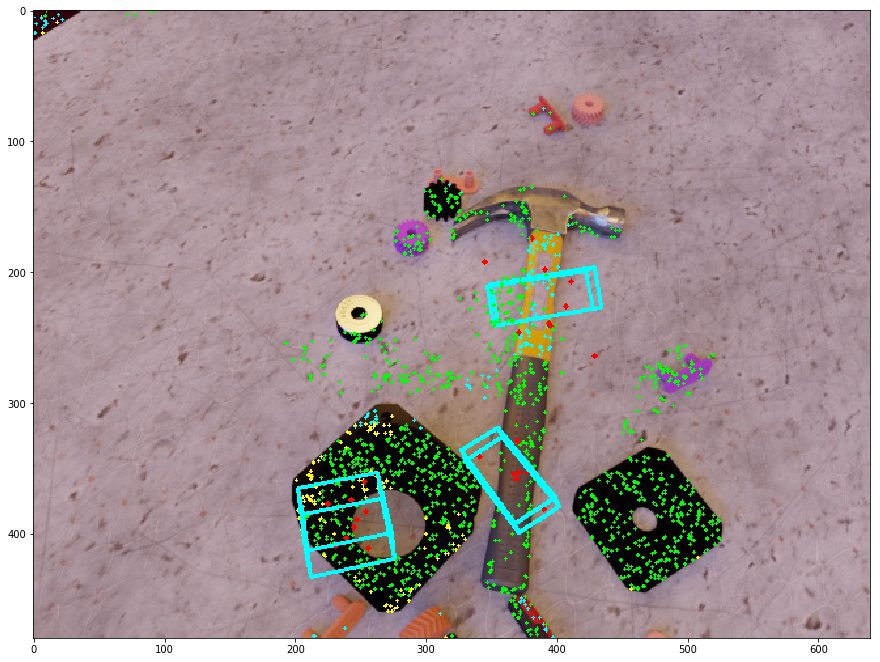

In [55]:
model = PVN3D(
                num_classes=config.n_objects, pcld_input_channels=6, pcld_use_xyz=True,
                num_points=config.n_sample_points, num_kps=config.n_keypoints
                    ).cuda()
model = convert_model(model)
model.cuda()
if checkpoint is not None:
    checkpoint_status = load_checkpoint(
        model, None, filename=checkpoint[:-8]
    )
model = nn.DataParallel(model)


if model.training:
    print('model state in training')
else:
    print('model state not in training')

#get_csv(model)
cls_ids, poses, pcld, kps,mesh,corners,K, rgb_labeled_bb = evaluate(0,1,model)
show_result(cls_ids, poses, kps,mesh,corners,pcld,K,rgb_labeled_bb)


In [59]:
dat_dir = '/home/kulunu/Desktop/ADAPT_Competition/ADAPT_Pose_Estimation/ADAPT_FB2/validation/'

scene_id_leading_zeros = 6
img_id_leading_zeros = 6
rgb_format = '.jpg'
dpt_format = '.png'
use_given_K = True

loading pretrained mdl.
model state in training
Valid points are more than configured
The shape of pred_kp_of : torch.Size([1, 8, 12288, 3])
The shape of pred_seg : torch.Size([1, 12288, 4])
The shape of pred_ctr_of : torch.Size([12288, 3])
classes_rgbd : torch.Size([1, 12288])
shape of pcld : torch.Size([12288, 3])
The shape of pred_ctr : torch.Size([12288, 3])
The shape of pred_kp : torch.Size([8, 12288, 3])
The shape of mask : torch.Size([12288])
The array pred_cls_ids : [2 3]
cls_msk_shape torch.Size([12288])
cls_voted_kps_shape torch.Size([8, 34, 3])
cls_msk_shape torch.Size([12288])
cls_voted_kps_shape torch.Size([8, 236, 3])
used [[615.13970269   0.         322.78683466]
 [  0.         615.43236419 244.22407518]
 [  0.           0.           1.        ]]
rgb_labeled (480, 640, 3)
rgb_kps (480, 640, 3)
(8, 2)
rgb_labeled (480, 640, 3)
used [[615.13970269   0.         322.78683466]
 [  0.         615.43236419 244.22407518]
 [  0.           0.           1.        ]]
rgb_labeled (48

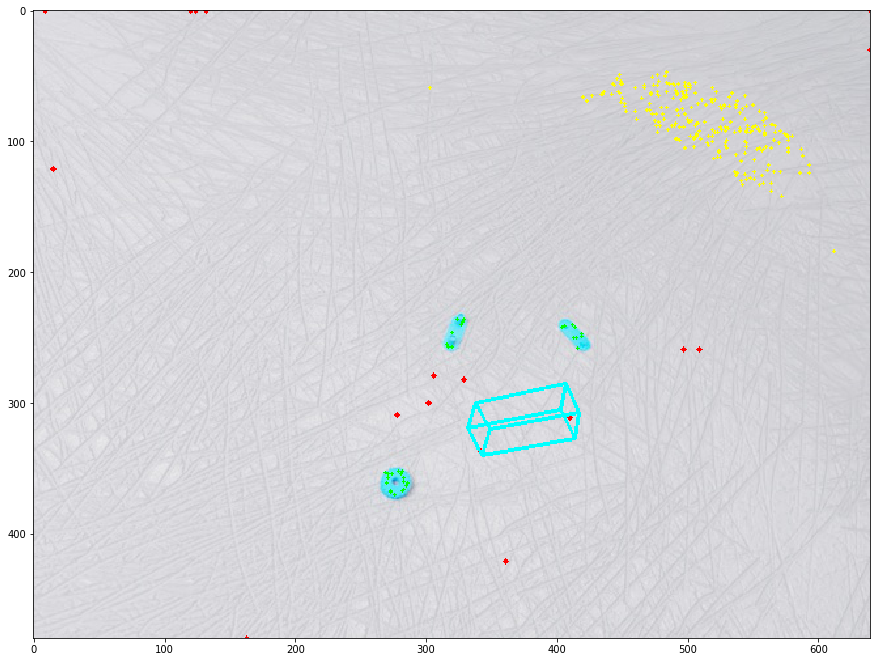

In [61]:
model = PVN3D(
                num_classes=config.n_objects, pcld_input_channels=6, pcld_use_xyz=True,
                num_points=config.n_sample_points, num_kps=config.n_keypoints
                    ).cuda()
model = convert_model(model)
model.cuda()
if checkpoint is not None:
    checkpoint_status = load_checkpoint(
        model, None, filename=checkpoint[:-8]
    )
model = nn.DataParallel(model)


if model.training:
    print('model state in training')
else:
    print('model state not in training')

#get_csv(model)
cls_ids, poses, pcld, kps,mesh,corners,K, rgb_labeled_bb = evaluate(1,3,model)
show_result(cls_ids, poses, kps,mesh,corners,pcld,K,rgb_labeled_bb)

In [62]:
dat_dir = '/home/kulunu/PVN3D/pvn3d/datasets/Adapt/Adapt_dataset'

scene_id_leading_zeros = 0
img_id_leading_zeros = 0
rgb_format = '.png'
dpt_format = '.png'
use_given_K = False

loading pretrained mdl.
model state in training
Valid points are more than configured
The shape of pred_kp_of : torch.Size([1, 8, 12288, 3])
The shape of pred_seg : torch.Size([1, 12288, 4])
The shape of pred_ctr_of : torch.Size([12288, 3])
classes_rgbd : torch.Size([1, 12288])
shape of pcld : torch.Size([12288, 3])
The shape of pred_ctr : torch.Size([12288, 3])
The shape of pred_kp : torch.Size([8, 12288, 3])
The shape of mask : torch.Size([12288])
The array pred_cls_ids : [1 2 3]
cls_msk_shape torch.Size([12288])
cls_voted_kps_shape torch.Size([8, 847, 3])
cls_msk_shape torch.Size([12288])
cls_voted_kps_shape torch.Size([8, 257, 3])
cls_msk_shape torch.Size([12288])
cls_voted_kps_shape torch.Size([8, 289, 3])
used [[615.13970269   0.         322.78683466]
 [  0.         615.43236419 244.22407518]
 [  0.           0.           1.        ]]
rgb_labeled (480, 640, 3)
rgb_kps (480, 640, 3)
(8, 2)
rgb_labeled (480, 640, 3)
used [[615.13970269   0.         322.78683466]
 [  0.         615.

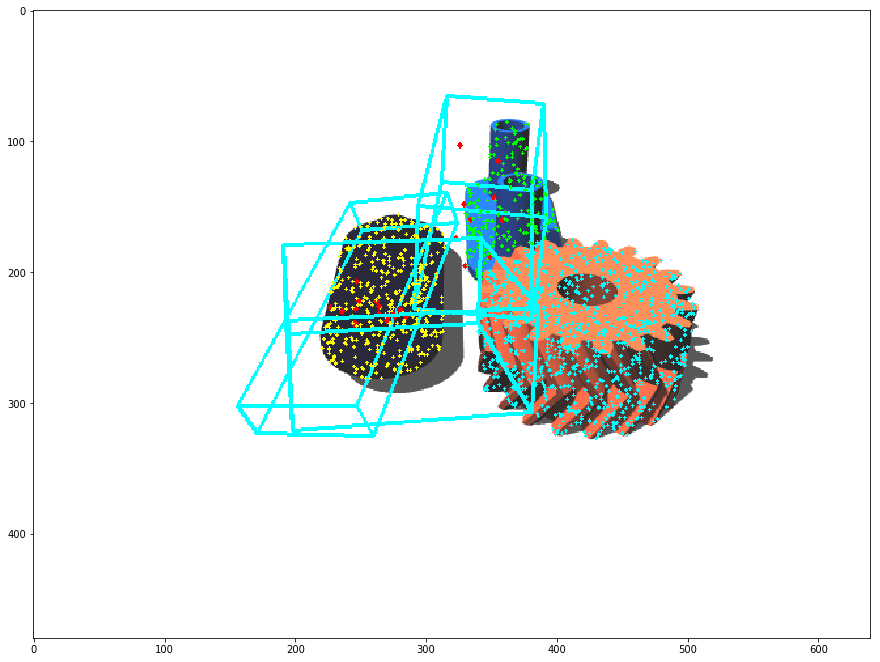

In [41]:
model = PVN3D(
                num_classes=config.n_objects, pcld_input_channels=6, pcld_use_xyz=True,
                num_points=config.n_sample_points, num_kps=config.n_keypoints
                    ).cuda()
model = convert_model(model)
model.cuda()
if checkpoint is not None:
    checkpoint_status = load_checkpoint(
        model, None, filename=checkpoint[:-8]
    )
model = nn.DataParallel(model)


if model.training:
    print('model state in training')
else:
    print('model state not in training')

#get_csv(model)
cls_ids, poses, pcld, kps,mesh,corners,K, rgb_labeled_bb = evaluate(0,1,model)
show_result(cls_ids, poses, kps,mesh,corners,pcld,K,rgb_labeled_bb)